In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show Code"></form>''')

# **Capstone Project 1: Statistical Data Analysis**

In [2]:
# Import useful libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from collections import defaultdict

import matplotlib as mpl
import seaborn as sns

sns.set(style ='white',font_scale=1.25)

%matplotlib inline

In [3]:
with open('../data/01-House-Price/wrangled_data.pkl','rb') as file:
    housing_orig, FEATURES = pickle.load(file)

In [4]:
housing = housing_orig.copy()
housing.head()
y = housing.SalePrice

# 1. Numerical Features

In [5]:
FEATURES['num'] = [feat for feat in FEATURES['num'] if feat != 'log1p(GrLivArea)']
housing_num = housing[FEATURES['num']]

## 1.1 Correlation amongst numerical features

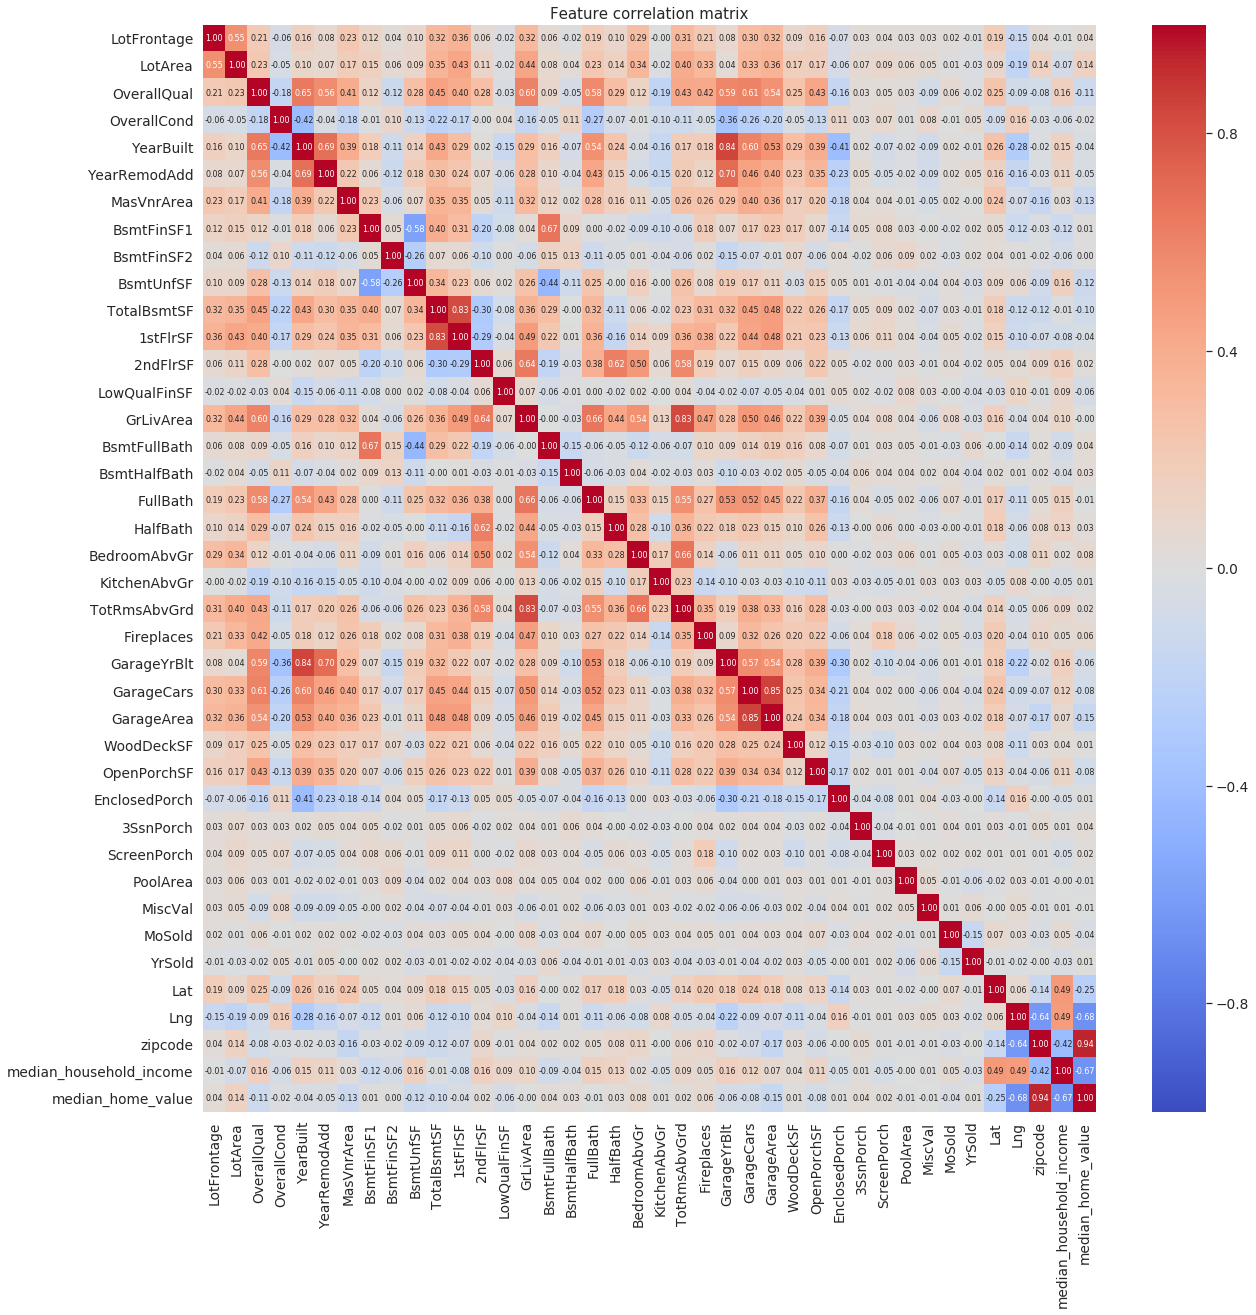

In [6]:
plt.figure(figsize=(20,20))
sns.heatmap(housing_num.corr(method='spearman'),
            vmax=1,vmin=-1,annot=True,
            cmap='coolwarm',
            fmt='.2f',annot_kws={'size':8})
_=plt.title("Feature correlation matrix")

Several numerical features are highly correlated with one another. Highest positive correlation is between house and garage year built (__YearBuilt__ and __GarageYrBlt__). This is not unexpected, as most house garages are built along with the house itself. A new feature called __GarageYrBltMinusYearBuilt__ is created, which models the difference between the year in which the garage and the house was built.

Second highest positive correlation is between total number of rooms (__TotRmsAbvGrd__) and total square feet area above ground (__GrLivArea__). This is also expected as houses with greater area tend to have more number of rooms. A new feature called __AreaPerRoom__ is added, which models the average area per room by dividing the __TotRmsAbvGrd__ by __GrLivArea__. 

Let’s check the correlation matrix again. 


In [7]:
def addFeature(test_df, main_df, feature_list):
    for feat in feature_list:
        main_df[feat] = test_df[feat]
        if main_df[feat].dtypes != 'object':
            FEATURES['num'].append(feat)
        elif main_df[feat].dtypes == 'object':
            FEATURES['cat'].append(feat)
    return main_df

In [8]:
housing_num['AreaPerRoom'] = housing_num['GrLivArea'].divide(housing_num.TotRmsAbvGrd)
housing_num['GarageYrBltMinusYearBuilt'] = housing_num['GarageYrBlt'].subtract(housing_num.YearBuilt)

housing = addFeature(housing_num,housing,['AreaPerRoom','GarageYrBltMinusYearBuilt'])

/home/climbach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/climbach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


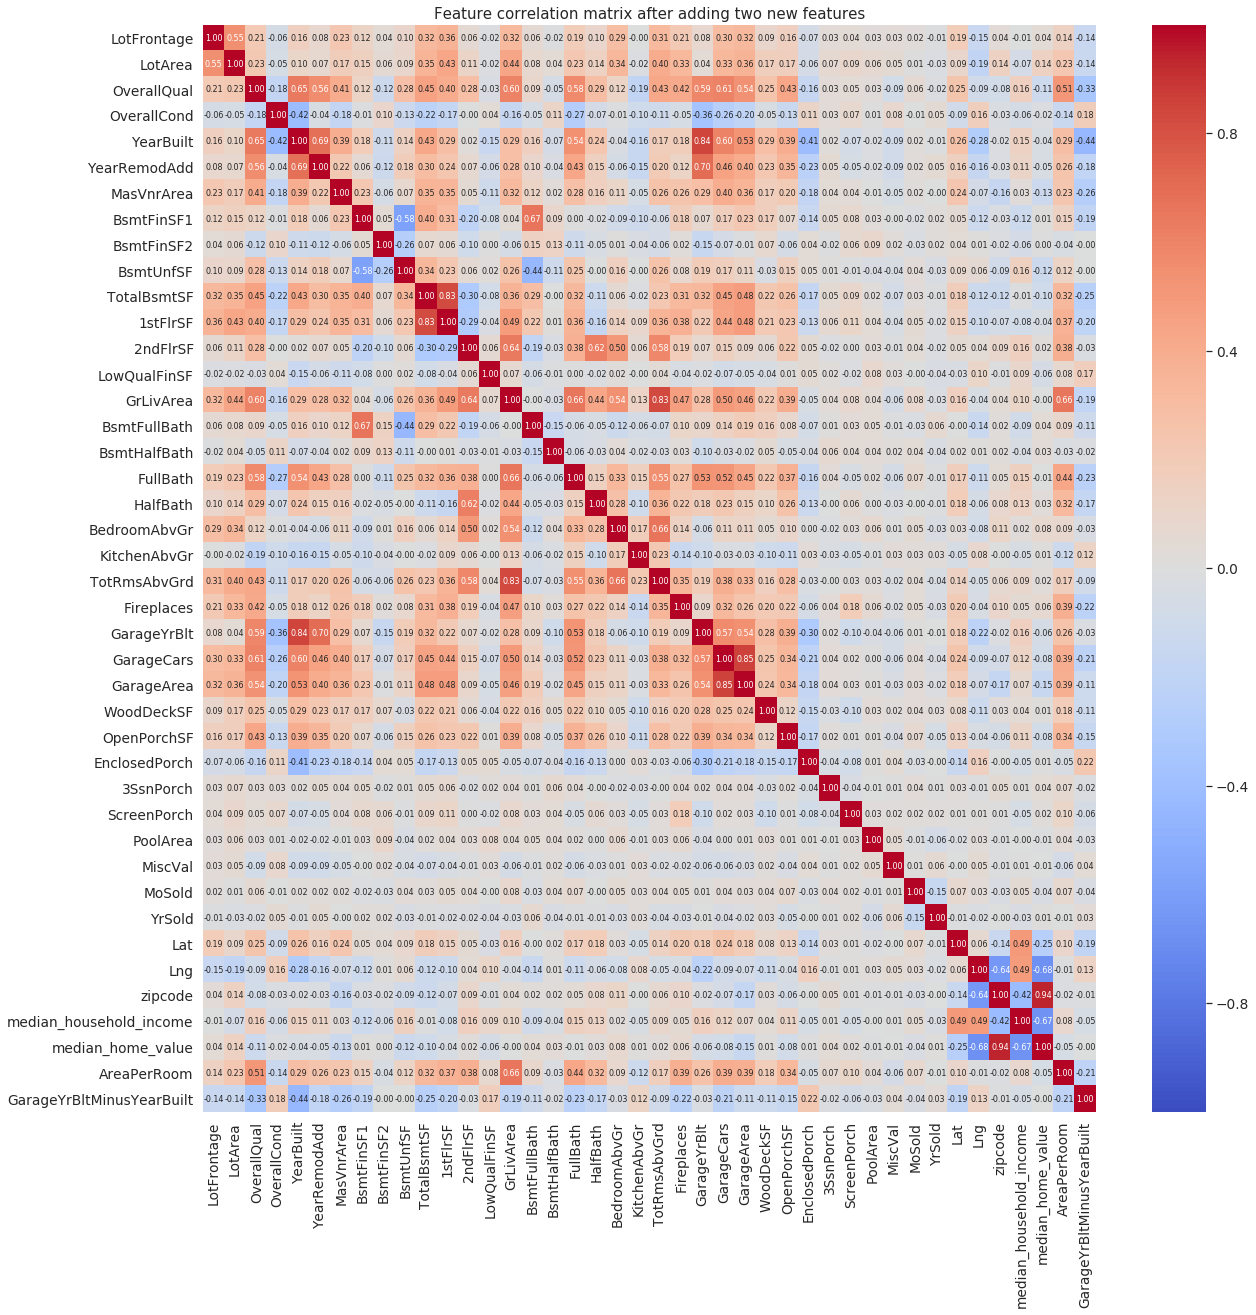

In [9]:
plt.figure(figsize=(20,20))
sns.heatmap(housing_num.corr(method='spearman'),
            vmax=1,vmin=-1,annot=True,
            cmap='coolwarm',
            fmt='.2f',annot_kws={'size':8})
_=plt.title("Feature correlation matrix after adding two new features")

Unlike the parent features, the newly added features (__AreaPerRoom__ and __GarageYrBltMinusYearBuilt__) are not that highly correlated with the rest of the features. Neither are they highly correlated with the parent features. 

### 1.2 Correlation with Sale Price

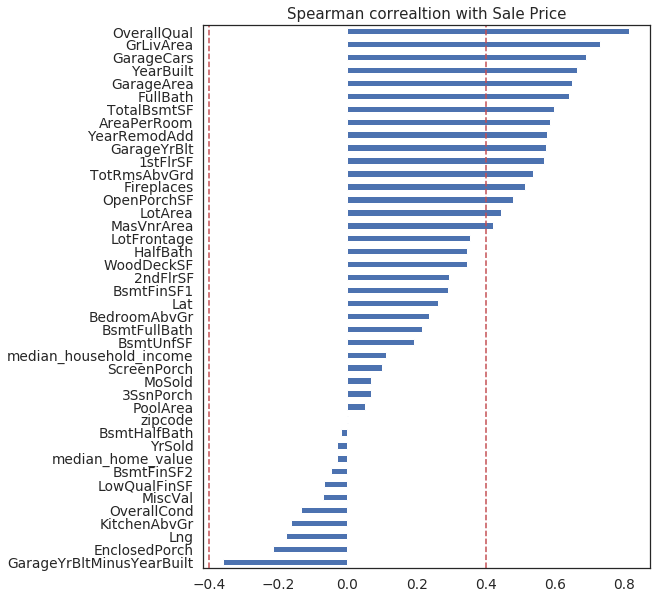

In [10]:
housing_num.corrwith(y,method='spearman').sort_values(ascending=True).plot.barh(figsize=(8,10),title = 'Spearman correaltion with Sale Price')
plt.axvline(x=0.4,linestyle='--',color='r')
plt.axvline(x=-0.4,linestyle='--',color='r')

Several features are highly correlated (> 0.4) with the sale price. One of the engineered (newly added) features, __AreaPerRoom__, is also highly correlated (~0.6) with the sale price. In fact, it is more correlated than one of its parent features from which it is derived (__TotRmsAbvGrd__). __GarageYrBlitMinusYearBuilt__ is another engineered feature. It has the highest negative correlation with the sale price. Both engineered features are candidates for predicting the sale price. 

## 2. Categorical Features
### 2.1 Non-parametric ANOVA

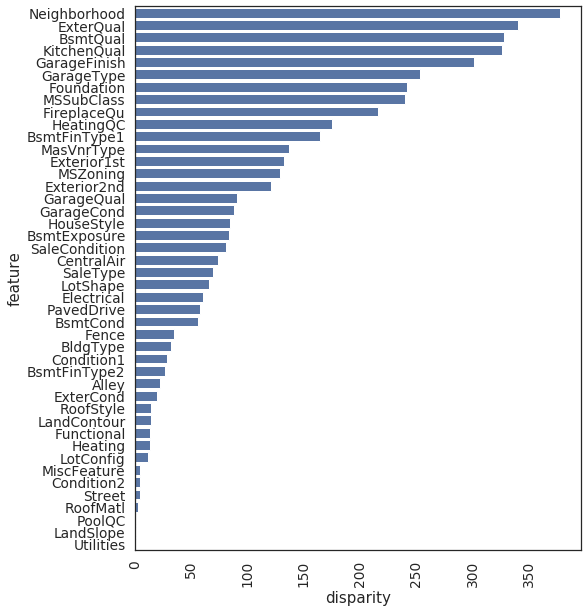

In [11]:
import scipy.stats as stats
housing_cat = housing[FEATURES['cat']]
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = frame.drop('SalePrice',axis=1).columns
    pvals = []
    for c in frame.drop('SalePrice',axis=1).columns:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.kruskal(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval').reset_index(drop=True)

a = anova(housing_cat.join(housing.SalePrice))
a['disparity'] = np.log(1./a['pval'].values)
plt.figure(figsize=(8,10))
sns.barplot(x='disparity',y='feature',data=a,color=sns.color_palette(n_colors=1)[0])
x=plt.xticks(rotation=90)

The above bar plot shows influence of each categorical feature on the sale price. Features with higher disparity have greater influence on the sale price.

## Ordinal Features

Description of following categorical feature indicate they have ordinal categories
- LandSlope
- ExterQual
- ExterCond
- BsmtQual
- BsmtCond
- BsmtExposure
- BsmtFinType1
- BsmtFinType2
- HeatingQC
- KitchenQual
- FireplaceQu
- GarageFinish
- GarageQual
- GarageCond
- PavedDrive
- PoolQC

In [12]:
ordinal_map = {'LandSlope':{'Gtl':0,'Mod':1,'Sev':2},
               'ExterQual':{'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0},
               'ExterCond':{'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0},
               'BsmtQual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'Missing':0}, # Houses that don't have a basement are assigned Typical/Average rating
               'BsmtCond':{'Gd':4, 'TA':3, 'Fa':2, 'Po':1,'Missing':0},
               'BsmtExposure':{'Gd':4,'Av':3,'Mn':2,'No':1,'Missing':0},
               'BsmtFinType1': {'Missing': 0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6},
               'BsmtFinType2': {'Missing': 0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6},
               'HeatingQC':{'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4},
               'KitchenQual':{'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0},
               'FireplaceQu':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'Missing':0},
               'GarageFinish':{'Fin':3, 'RFn':2, 'Unf':1, 'Missing':0},
               'GarageQual':{'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'Missing':0},
               'GarageCond':{'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'Missing':0},
               'PavedDrive':{'Y':2, 'P':1, 'N':0},
               'PoolQC':{'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Missing':0}}

In [13]:
housing_cat_encoded = housing[FEATURES['cat']].replace(ordinal_map)
# convert the ordinal features to numeric data type (float)
for col in housing_cat_encoded[list(ordinal_map.keys())]:
    housing_cat_encoded[col] = housing_cat_encoded[col].astype(float)
housing_cat_encoded[ordinal_map.keys()].head()

,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC
Id,,,,,,,,,,,,,,,,
1,0.0,3.0,2.0,4.0,3.0,1.0,6.0,1.0,4.0,3.0,0.0,2.0,3.0,3.0,2.0,0.0
2,0.0,2.0,2.0,4.0,3.0,4.0,5.0,1.0,4.0,2.0,3.0,2.0,3.0,3.0,2.0,0.0
3,0.0,3.0,2.0,4.0,3.0,2.0,6.0,1.0,4.0,3.0,3.0,2.0,3.0,3.0,2.0,0.0
4,0.0,2.0,2.0,3.0,4.0,1.0,5.0,1.0,3.0,3.0,4.0,1.0,3.0,3.0,2.0,0.0
5,0.0,3.0,2.0,4.0,3.0,3.0,6.0,1.0,4.0,3.0,3.0,2.0,3.0,3.0,2.0,0.0


### One hot ecoding: one hot encode following features

- MSSubClass
- MSZoning
- Street
- Alley
- LotShape
- LandContour
- Utilities
- LotConfig
- Neighborhood
- Condition1
- Condition2
- BldgType
- HouseStyle
- RoofStyle
- RoofMatl
- Exterior1st
- Exterior2nd
- MasVnrType
- Foundation
- Heating
- CentralAir
- Electrical
- Functional
- GarageType
- Fence
- MiscFeature
- SaleType
- SaleCondition

In [14]:
housing_cat_encoded = pd.get_dummies(housing_cat_encoded,drop_first=True)

In [15]:
FEATURES['encoded_cat'] = []
for col in housing_cat_encoded.columns:
    FEATURES['encoded_cat'].append(col)

In [16]:
train = pd.concat([housing_cat_encoded,housing[FEATURES['num']]],axis=1)
y = housing['log1p(SalePrice)']

## 3. Interactions
- Check pairwise feature correlations
- Create interactions of feature pairs with high correlations (> 0.4)

In [17]:
corr_df = train.corr()
''' Create a dictionary with feature pairs as keys and their correlations as values'''
corr_dict = {}
for key, val in corr_df.unstack().to_dict().items():
    if (key == key[::-1]) or (key in corr_dict) or (key[::-1] in corr_dict):
        pass
    else:
        corr_dict[key] = val

In [18]:
'''Find feature pairs with corr > 0.4'''
high_corr_dict = {}
targetCorr = 0.4
for key, val in corr_dict.items():
    if val > targetCorr:
        high_corr_dict[key] = val
        
print('Total pairs with corr greater than %.2f: %i' %(targetCorr,len(high_corr_dict)))

'''Sort corr dict in descending order'''
from collections import OrderedDict
high_corr_dict = OrderedDict(sorted(high_corr_dict.items(), key=lambda x: x[1],reverse=True))
#print(high_corr_dict)

Total pairs with corr greater than 0.40: 201


In [19]:
interactions = []
for feat1, feat2 in high_corr_dict:
    train['X'.join([feat1,feat2])] = train[feat1] * train[feat2]
    interactions.append('X'.join([feat1,feat2]))

In [20]:
print("Total number of examples : " + str(train.shape[0]))
print("Total number of Features : " + str(train.shape[1]))

Total number of examples : 1443
Total number of Features : 431
